In [161]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [162]:
# Reading the data
data = pd.read_excel(r'C:\Users\sreeh\DSA\Project testing\ECommerceDataset.xlsx',sheet_name='E Comm')
pd.set_option('display.max_columns', None)

In [163]:
# Displaying a small chunk of data.
data.head()

,CustomerID,Churn,Tenure,PreferredLoginDevice,CityTier,WarehouseToHome,PreferredPaymentMode,Gender,HourSpendOnApp,NumberOfDeviceRegistered,PreferedOrderCat,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,OrderAmountHikeFromlastYear,CouponUsed,OrderCount,DaySinceLastOrder,CashbackAmount
0,50001,1,4.0,Mobile Phone,3,6.0,Debit Card,Female,3.0,3,Laptop & Accessory,2,Single,9,1,11.0,1.0,1.0,5.0,159.93
1,50002,1,NaN,Phone,1,8.0,UPI,Male,3.0,4,Mobile,3,Single,7,1,15.0,0.0,1.0,0.0,120.90
2,50003,1,NaN,Phone,1,30.0,Debit Card,Male,2.0,4,Mobile,3,Single,6,1,14.0,0.0,1.0,3.0,120.28
3,50004,1,0.0,Phone,3,15.0,Debit Card,Male,2.0,4,Laptop & Accessory,5,Single,8,0,23.0,0.0,1.0,3.0,134.07
4,50005,1,0.0,Phone,1,12.0,CC,Male,NaN,3,Mobile,5,Single,3,0,11.0,1.0,1.0,3.0,129.60


In [164]:
# Changing the same values with different representations into 1 value.
data['PreferredLoginDevice'] = data['PreferredLoginDevice'].replace('Phone', 'Mobile Phone')

In [165]:
data['PreferredPaymentMode'] = data['PreferredPaymentMode'].replace('CC', 'Credit Card').replace('COD', 'Cash on Delivery')

In [166]:
data['PreferedOrderCat'] = data['PreferedOrderCat'].replace('Mobile', 'Mobile Phone')

In [167]:
data['Churn'].value_counts(normalize=True)*100

0    83.161634
1    16.838366
Name: Churn, dtype: float64

We can see that the data is highly imbalanced

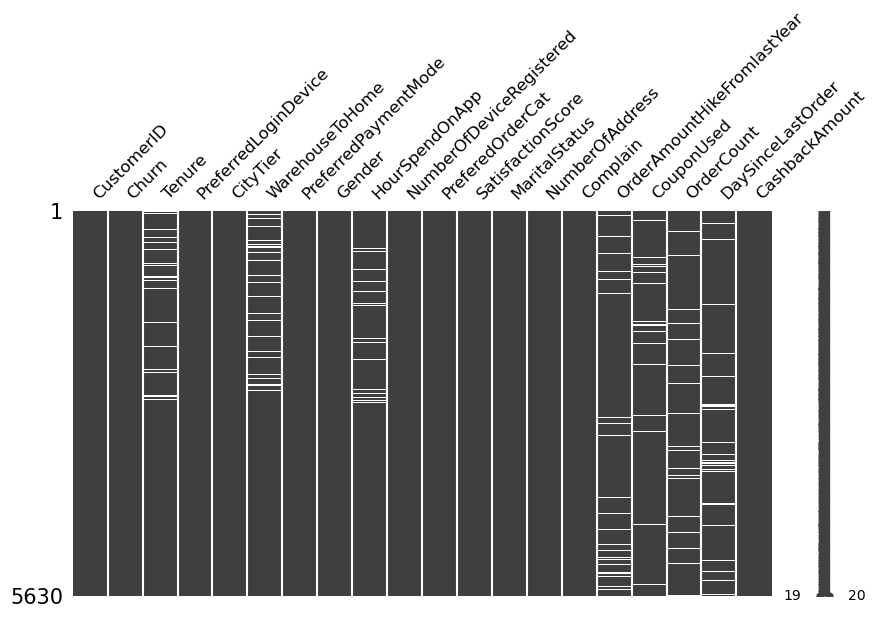

In [168]:
# Install using pip install missingno
# Show the missing values as a Matrix
import missingno as msno
msno.matrix(data,figsize=(10,5), fontsize=12)
plt.show()

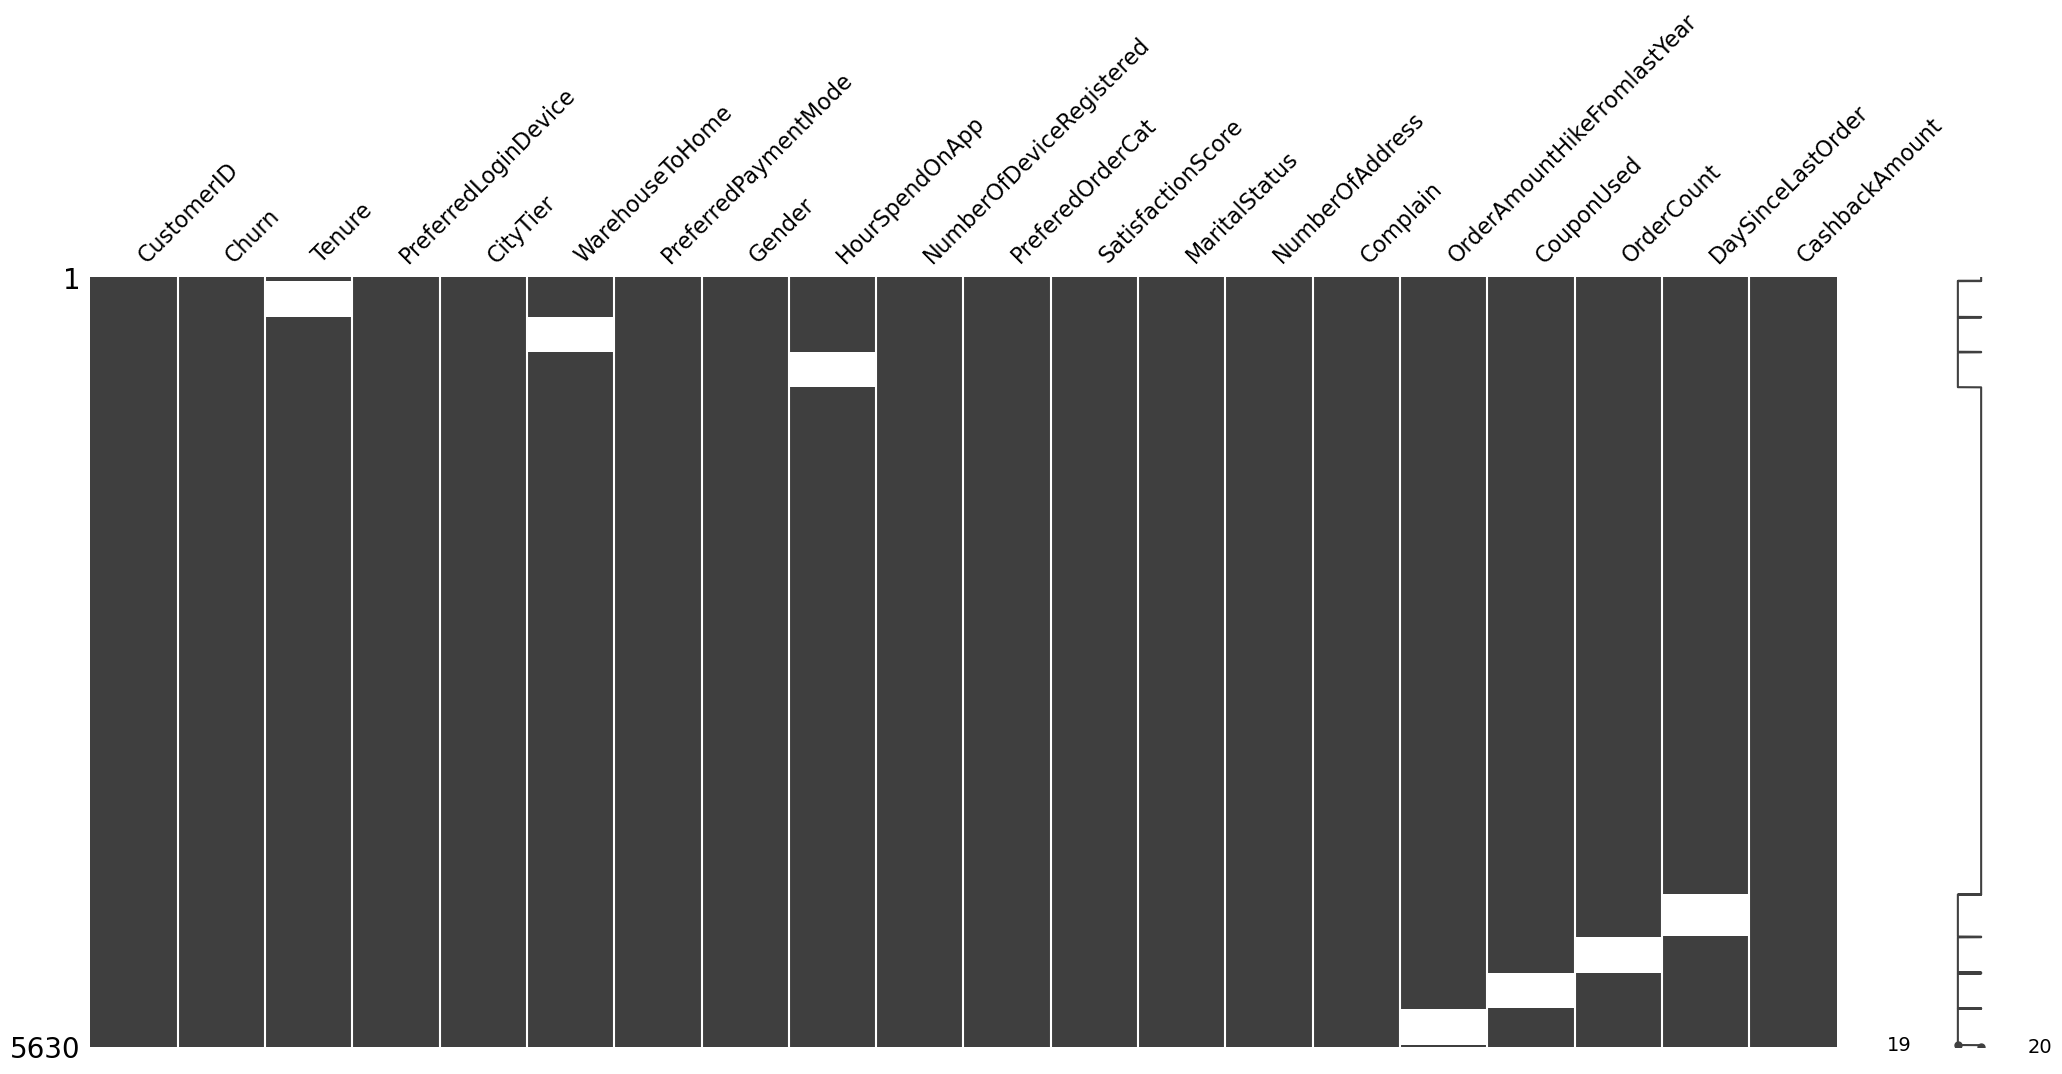

In [169]:
# Sorting the missing values by CashbackAmount
msno.matrix(data.sort_values(by='CashbackAmount'))
plt.show()

We can see that the data is Missing At Random.

In [170]:
# Fill the missing values using KNN.
missing_cols = [col for col in data.columns if data[col].isnull().any()]
from sklearn.impute import KNNImputer
impute_knn = KNNImputer(n_neighbors=5)
data_missing = data[missing_cols]
imputed_data = impute_knn.fit_transform(data_missing)
data_imputed = pd.concat([data.drop(missing_cols, axis=1), pd.DataFrame(imputed_data, columns=missing_cols)], axis=1)

In [171]:
q1 = data_imputed.copy()
avg_days_since_last_order = round(q1['DaySinceLastOrder'].mean())

In [172]:
customer_count_by_segment = q1['Segment'] = pd.cut(q1['DaySinceLastOrder'], bins=[-1,0,5, 10, 15, 20, 100], labels=['Purchased today','1-5 days', '6-10 days', '10-15 days', '15-20 days', 'More than 20 days'])

In [173]:
print('The average number of days since the last order for all customers is:', avg_days_since_last_order)

print('Number of customers in each segment:')
print(q1['Segment'].value_counts().sort_index())

The average number of days since the last order for all customers is: 5
Number of customers in each segment:
Purchased today       496
1-5 days             3120
6-10 days            1691
10-15 days            280
15-20 days             40
More than 20 days       3
Name: Segment, dtype: int64


In [174]:
counts = q1['Segment'].value_counts().sort_index()
counts

Purchased today       496
1-5 days             3120
6-10 days            1691
10-15 days            280
15-20 days             40
More than 20 days       3
Name: Segment, dtype: int64

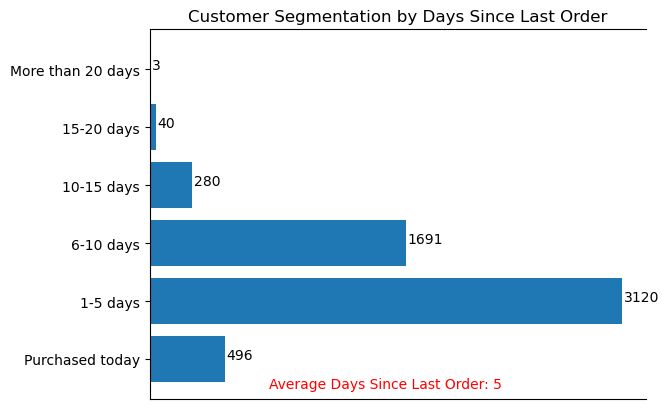

In [175]:
fig, ax = plt.subplots()

ax.barh(counts.index, counts.values)

for i, v in enumerate(counts.values):
    ax.text(v+10, i, str(v), color='black')
    
ax.spines['right'].set_visible(False)
ax.xaxis.set_visible(False)
plt.text(x=counts.max() / 2, y=-0.5, s=f'Average Days Since Last Order: {avg_days_since_last_order}', fontsize=10, color='red', ha='center')
plt.title('Customer Segmentation by Days Since Last Order')

plt.show()

There seems to a serious drop in the number of customers who have order after a 10 days have passed(at-risk customers). Let us see how many of them are churned.

In [176]:
q1_risk = q1[q1['DaySinceLastOrder'] >= 10 ]
at_risk_count = q1_risk['DaySinceLastOrder'].count()
print("Count of Customers at risk  = ",at_risk_count)
print("Count of Customers at risk & didn't churn = ",q1_risk['DaySinceLastOrder'][q1_risk['Churn'] == 0].count())
print("Count of Customers at risk & churned already  = ",q1_risk['DaySinceLastOrder'][q1_risk['Churn'] == 1].count())

Count of Customers at risk  =  481
Count of Customers at risk & didn't churn =  447
Count of Customers at risk & churned already  =  34


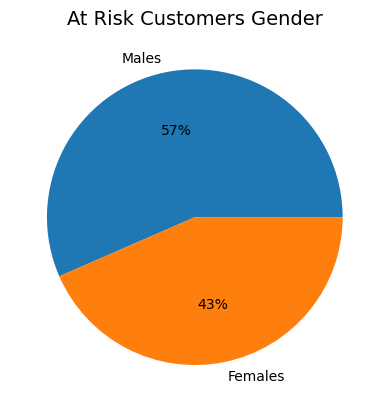

In [177]:
plt.title('At Risk Customers Gender', size = 14)
plt.pie((q1_risk['Gender'].value_counts() / at_risk_count *100),labels = ['Males','Females'], autopct='%.0f%%')
plt.show()

Men are likely more to be churned than women.

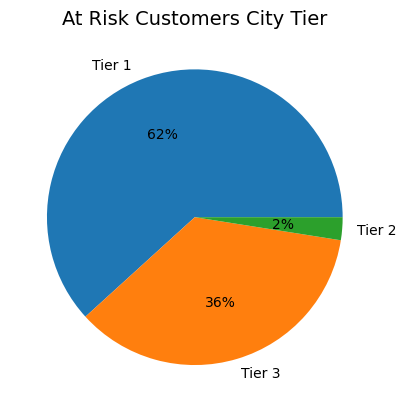

In [178]:
plt.title('At Risk Customers City Tier', size = 14)
plt.pie((q1_risk['CityTier'].value_counts() / at_risk_count *100),labels = ['Tier 1 ','Tier 3','Tier 2'], autopct='%.0f%%')
plt.show()

At risk customers are concentrated in Tier 1 city.

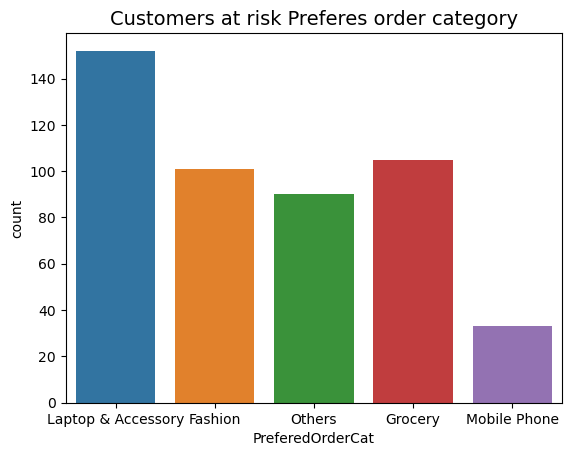

In [179]:
plt.title('Customers at risk Preferes order category', size = 14)
sns.countplot(data=q1_risk, x = 'PreferedOrderCat')
plt.show()

We can see that Laptop and their accessories is more popular among the at risk customers

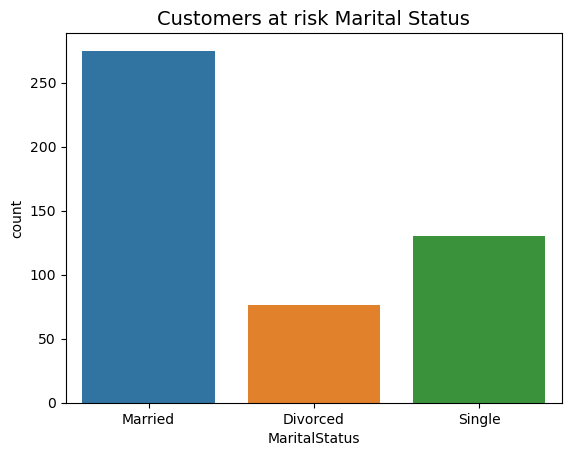

In [180]:
plt.title('Customers at risk Marital Status', size = 14)
sns.countplot(data=q1_risk, x = 'MaritalStatus')
plt.show()

There are more married customers among the at-risk customers.

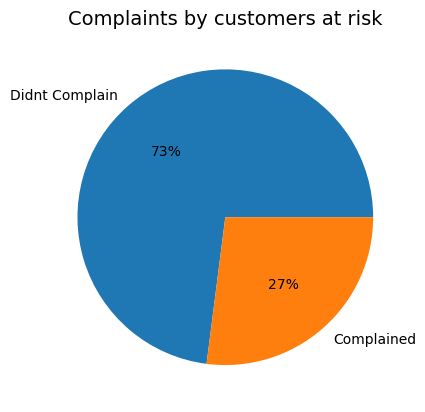

In [181]:
plt.title('Complaints by customers at risk', size = 14)
plt.pie((q1_risk['Complain'].value_counts() / at_risk_count *100),labels = ['Didnt Complain','Complained'], autopct='%.0f%%')
plt.show()

There doesn't seem to be a significant co-relation between complaints and at risk of being churned.

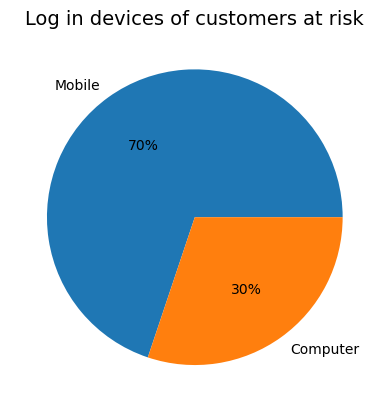

In [182]:
plt.title('Log in devices of customers at risk', size = 14)
plt.pie((q1_risk['PreferredLoginDevice'].value_counts() / at_risk_count *100),labels = ['Mobile','Computer'], autopct='%.0f%%')
plt.show()

More customers in this risk category use their Mobiles as the login device.

In [183]:
df2 = data_imputed.copy()

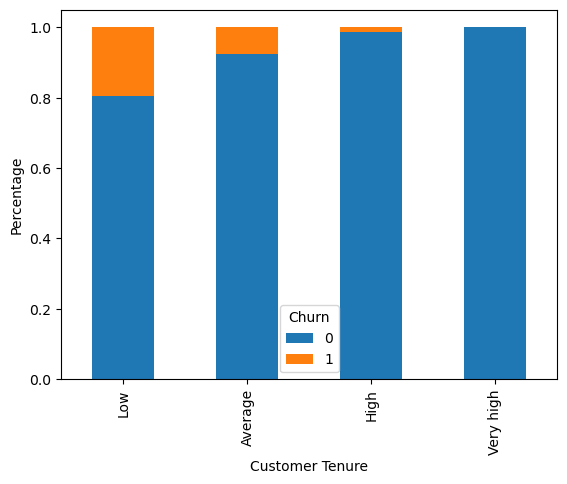

In [184]:
bins=[0,10,20,30,70]
group=['Low','Average','High', 'Very high']
df2['tenure_bin']=pd.cut(df2['Tenure'],bins=bins,labels=group)
tenure_bin=pd.crosstab(df2['tenure_bin'],df2['Churn'])
tenure_bin.div(tenure_bin.sum(1).astype(float), axis=0).plot(kind="bar", stacked=True)
plt.xlabel('Customer Tenure')
plt.ylabel('Percentage')
plt.show()

We can see that churn significantly reduces after 20 months of Tenure

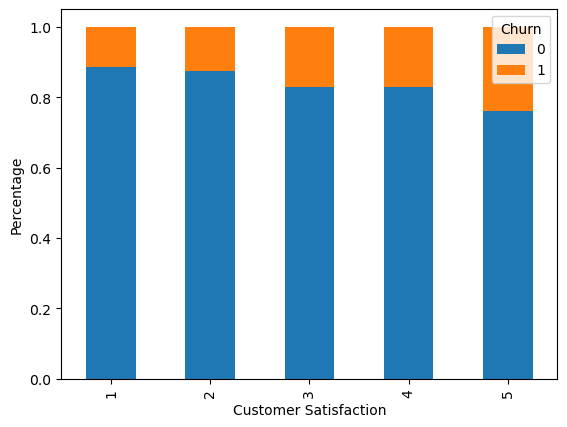

In [185]:
sscore=pd.crosstab(df2['SatisfactionScore'],df2['Churn'])
sscore.div(sscore.sum(1).astype(float), axis=0).plot(kind="bar", stacked=True)
plt.xlabel('Customer Satisfaction')
plt.ylabel('Percentage')
plt.show()

Strangely customer satisfaction score is not a good metric to determine churn. Churn is almost equally distributed throughout the customer satisfaction score.


In [186]:
df2.columns

Index(['CustomerID', 'Churn', 'PreferredLoginDevice', 'CityTier',
       'PreferredPaymentMode', 'Gender', 'NumberOfDeviceRegistered',
       'PreferedOrderCat', 'SatisfactionScore', 'MaritalStatus',
       'NumberOfAddress', 'Complain', 'CashbackAmount', 'Tenure',
       'WarehouseToHome', 'HourSpendOnApp', 'OrderAmountHikeFromlastYear',
       'CouponUsed', 'OrderCount', 'DaySinceLastOrder', 'tenure_bin'],
      dtype='object')

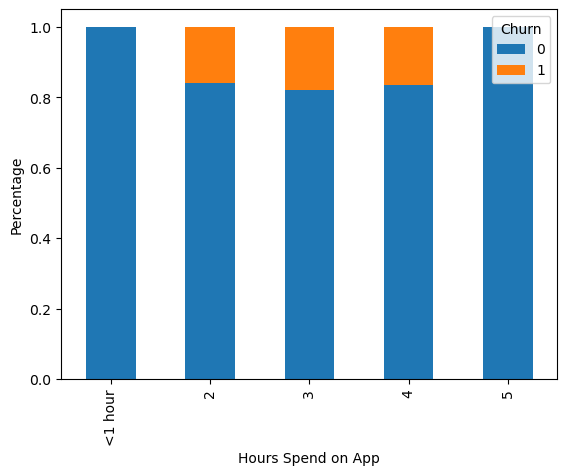

In [187]:
bins=[0,1,2,3,4,5]
group=['<1 hour','2','3','4','5']
df2['hspend']=pd.cut(df2['HourSpendOnApp'],bins=bins,labels=group)
hspend=pd.crosstab(df2['hspend'],df2['Churn'])
hspend.div(hspend.sum(1).astype(float), axis=0).plot(kind="bar", stacked=True)
plt.xlabel('Hours Spend on App')
plt.ylabel('Percentage')
plt.show()

Hours spend on App does not seem to affect the Churn

In [188]:
df2['OrderCount'] = round(df2['OrderCount'])

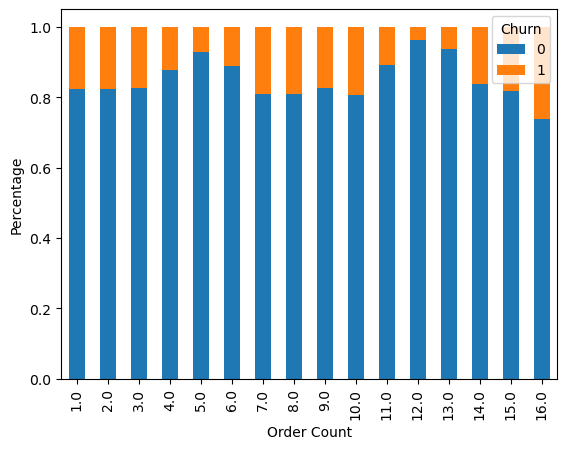

In [189]:
ocount=pd.crosstab(df2['OrderCount'],df2['Churn'])
ocount.div(ocount.sum(1).astype(float), axis=0).plot(kind="bar", stacked=True)
plt.xlabel('Order Count')
plt.ylabel('Percentage')
plt.show()

Order count doesn't seem to affect the Churn.

In [190]:
df2['WarehouseToHome'].value_counts(ascending=True)

127.0      1
20.2       1
32.6       1
11.4       1
23.4       1
        ... 
14.0     301
16.0     329
7.0      389
8.0      446
9.0      562
Name: WarehouseToHome, Length: 95, dtype: int64

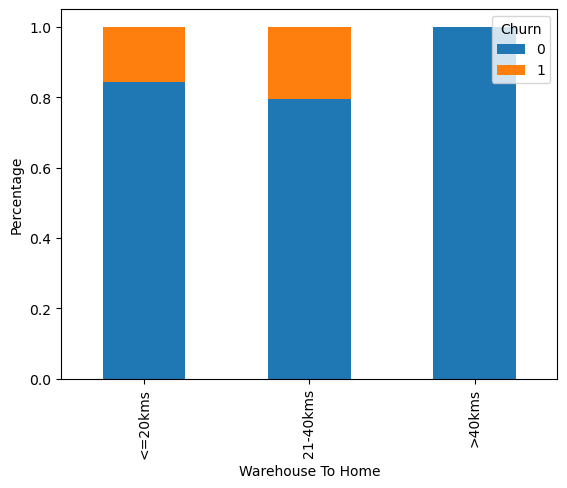

In [191]:
bins = [0, 20, 40,140]
group = ['<=20kms', '21-40kms', '>40kms']
df2['wdistance'] = pd.cut(df2['WarehouseToHome'], bins=bins, labels=group)
wdistance = pd.crosstab(df2['wdistance'], df2['Churn'])
wdistance_percent = wdistance.div(wdistance.sum(1).astype(float), axis=0)
wdistance_percent.plot(kind="bar", stacked=True)
plt.xlabel('Warehouse To Home')
plt.ylabel('Percentage')
plt.show()

Warehouse to house distance doesn't seem to affect Churn.

In [192]:
# After looking at the values and the EDA convert these values into object type as there is no scale
# of importance among the values.
data_imputed['CityTier'] = data_imputed['CityTier'].astype('object')
data_imputed['SatisfactionScore'] = data_imputed['SatisfactionScore'].astype('object')
data_imputed['Complain'] = data_imputed['Complain'].astype('object')

In [193]:
data_imputed.head()

,CustomerID,Churn,PreferredLoginDevice,CityTier,PreferredPaymentMode,Gender,NumberOfDeviceRegistered,PreferedOrderCat,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,CashbackAmount,Tenure,WarehouseToHome,HourSpendOnApp,OrderAmountHikeFromlastYear,CouponUsed,OrderCount,DaySinceLastOrder
0,50001,1,Mobile Phone,3,Debit Card,Female,3,Laptop & Accessory,2,Single,9,1,159.93,4.0,6.0,3.0,11.0,1.0,1.0,5.0
1,50002,1,Mobile Phone,1,UPI,Male,4,Mobile Phone,3,Single,7,1,120.90,9.8,8.0,3.0,15.0,0.0,1.0,0.0
2,50003,1,Mobile Phone,1,Debit Card,Male,4,Mobile Phone,3,Single,6,1,120.28,8.0,30.0,2.0,14.0,0.0,1.0,3.0
3,50004,1,Mobile Phone,3,Debit Card,Male,4,Laptop & Accessory,5,Single,8,0,134.07,0.0,15.0,2.0,23.0,0.0,1.0,3.0
4,50005,1,Mobile Phone,1,Credit Card,Male,3,Mobile Phone,5,Single,3,0,129.60,0.0,12.0,2.4,11.0,1.0,1.0,3.0


In [194]:
# Rounding the OrderCount because orders have to be whole numbers.
data_imputed['OrderCount'] = round(data_imputed['OrderCount'])

In [195]:
data_imputed.head()

,CustomerID,Churn,PreferredLoginDevice,CityTier,PreferredPaymentMode,Gender,NumberOfDeviceRegistered,PreferedOrderCat,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,CashbackAmount,Tenure,WarehouseToHome,HourSpendOnApp,OrderAmountHikeFromlastYear,CouponUsed,OrderCount,DaySinceLastOrder
0,50001,1,Mobile Phone,3,Debit Card,Female,3,Laptop & Accessory,2,Single,9,1,159.93,4.0,6.0,3.0,11.0,1.0,1.0,5.0
1,50002,1,Mobile Phone,1,UPI,Male,4,Mobile Phone,3,Single,7,1,120.90,9.8,8.0,3.0,15.0,0.0,1.0,0.0
2,50003,1,Mobile Phone,1,Debit Card,Male,4,Mobile Phone,3,Single,6,1,120.28,8.0,30.0,2.0,14.0,0.0,1.0,3.0
3,50004,1,Mobile Phone,3,Debit Card,Male,4,Laptop & Accessory,5,Single,8,0,134.07,0.0,15.0,2.0,23.0,0.0,1.0,3.0
4,50005,1,Mobile Phone,1,Credit Card,Male,3,Mobile Phone,5,Single,3,0,129.60,0.0,12.0,2.4,11.0,1.0,1.0,3.0


In [196]:
data_imputed['OrderCount'].value_counts()

2.0     2094
1.0     1801
3.0      409
4.0      227
7.0      219
5.0      198
8.0      184
6.0      154
9.0       69
11.0      55
12.0      55
10.0      41
14.0      37
15.0      33
13.0      31
16.0      23
Name: OrderCount, dtype: int64

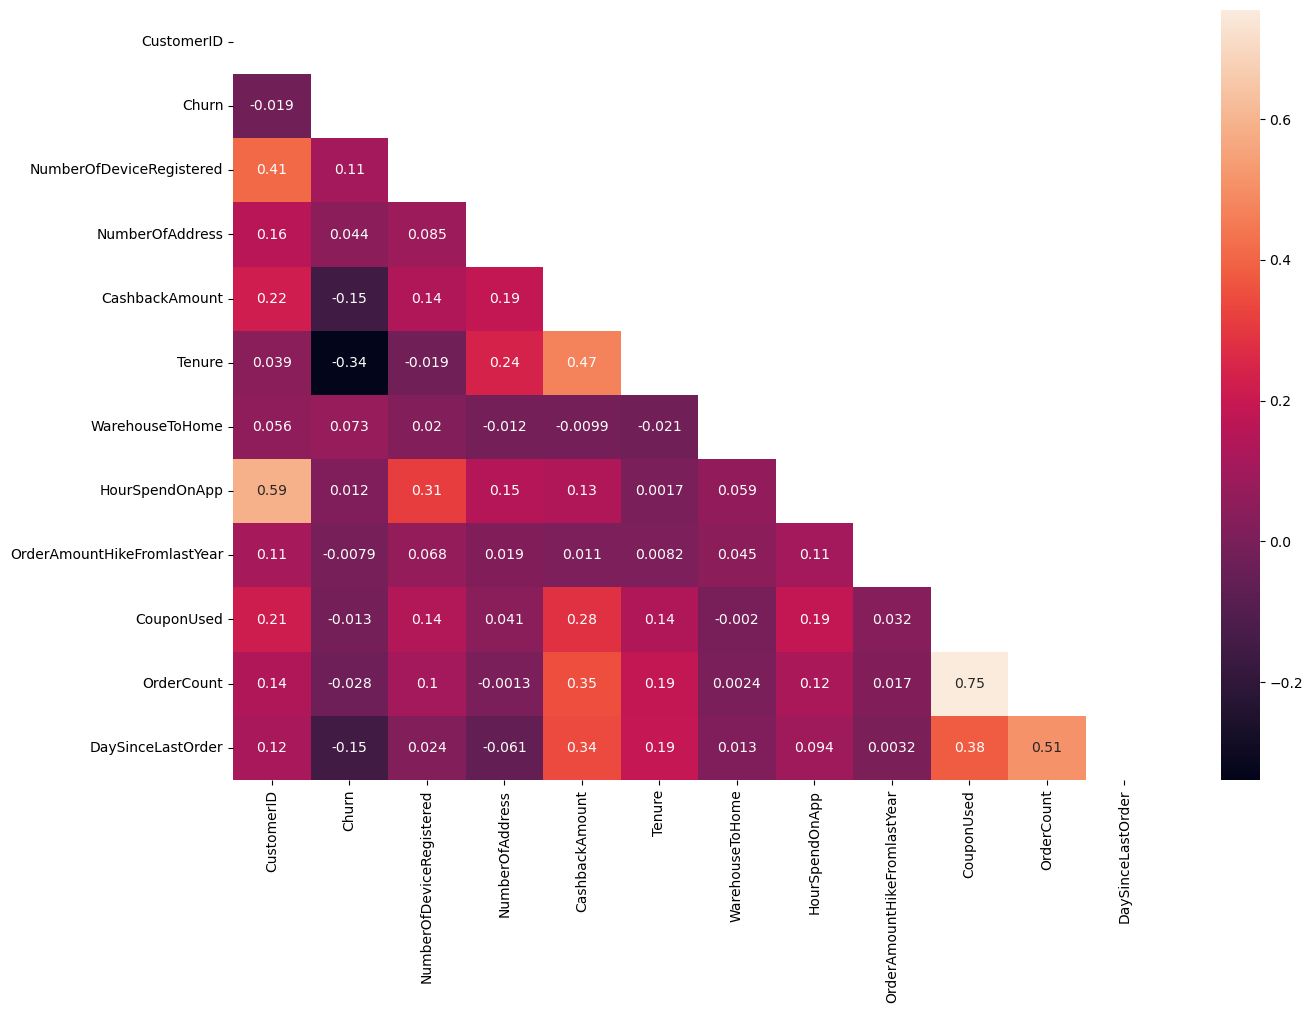

In [197]:
# Plotting a correlation matrix as a heatmap
plt.figure(figsize=(15, 10))
# Masking the top half
mask = np.triu(data_imputed.corr(numeric_only=True))
sns.heatmap(data_imputed.corr(numeric_only=True), annot=True, mask=mask)
plt.show()

In [198]:
data_imputed['Tenure'].mean()

10.079928952042629

In [199]:
data_imputed['Tenure'].describe()

count    5630.000000
mean       10.079929
std         8.432039
min         0.000000
25%         3.000000
50%         9.000000
75%        15.000000
max        61.000000
Name: Tenure, dtype: float64

In [200]:
data_imputed['NumberOfAddress'].mean()

4.214031971580817

In [201]:
# Winsorize the values above 99th percentile to 99th percentile
from scipy.stats.mstats import winsorize
winsorize(data_imputed['Tenure'], limits=(0, 0.01), inplace=True)

masked_array(data=[ 4. ,  9.8,  8. , ...,  1. , 23. ,  8. ],
             mask=False,
       fill_value=1e+20)

In [202]:
data_imputed['Tenure'].mean()

10.053108348134991

In [203]:
# Winsorize the values above 95th percentile to 95th percentile
winsorize(data_imputed['NumberOfAddress'], limits=(0, 0.05), inplace=True)

masked_array(data=[9, 7, 6, ..., 3, 4, 4],
             mask=False,
       fill_value=999999,
            dtype=int64)

In [204]:
data_imputed['NumberOfAddress'].mean()

4.1891651865008885

In [205]:
data_imputed['Tenure'].describe()

count    5630.000000
mean       10.053108
std         8.339132
min         0.000000
25%         3.000000
50%         9.000000
75%        15.000000
max        30.000000
Name: Tenure, dtype: float64

In [206]:
data_imputed['NumberOfAddress'].describe()

count    5630.000000
mean        4.189165
std         2.507956
min         1.000000
25%         2.000000
50%         3.000000
75%         6.000000
max        10.000000
Name: NumberOfAddress, dtype: float64

In [207]:
# Conducting Two Sample T-Test to see which numerical columns to select
from scipy.stats import ttest_ind
def num_stats(num_col):
    group_0 = data_imputed[data_imputed['Churn']==0][num_col]
    group_1 = data_imputed[data_imputed['Churn']==1][num_col]

    t_stat, p_value = ttest_ind(group_0,group_1,equal_var=False)

    print('P-value : ', p_value)
    if(p_value<0.05):
        print('Reject null hypothesis')
    else:
        print('Do not reject null hypothesis')

In [208]:
# Conducting chi-square test of independence on categorical columns.
from scipy.stats import chi2_contingency
def chisq_test(cat_col, df):
    CrossTabResult=pd.crosstab(index=df['Churn'], columns=df[cat_col])
    ChiSqResult = chi2_contingency(CrossTabResult)
        
    if (ChiSqResult[1] < 0.05):
        print('P-Value :', ChiSqResult[1])
        print('Reject null hypothesis')
    else:
        print('P-Value :', ChiSqResult[1])
        print('Do not reject null hypothesis')

In [209]:
data_imputed.head()

,CustomerID,Churn,PreferredLoginDevice,CityTier,PreferredPaymentMode,Gender,NumberOfDeviceRegistered,PreferedOrderCat,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,CashbackAmount,Tenure,WarehouseToHome,HourSpendOnApp,OrderAmountHikeFromlastYear,CouponUsed,OrderCount,DaySinceLastOrder
0,50001,1,Mobile Phone,3,Debit Card,Female,3,Laptop & Accessory,2,Single,9,1,159.93,4.0,6.0,3.0,11.0,1.0,1.0,5.0
1,50002,1,Mobile Phone,1,UPI,Male,4,Mobile Phone,3,Single,7,1,120.90,9.8,8.0,3.0,15.0,0.0,1.0,0.0
2,50003,1,Mobile Phone,1,Debit Card,Male,4,Mobile Phone,3,Single,6,1,120.28,8.0,30.0,2.0,14.0,0.0,1.0,3.0
3,50004,1,Mobile Phone,3,Debit Card,Male,4,Laptop & Accessory,5,Single,8,0,134.07,0.0,15.0,2.0,23.0,0.0,1.0,3.0
4,50005,1,Mobile Phone,1,Credit Card,Male,3,Mobile Phone,5,Single,3,0,129.60,0.0,12.0,2.4,11.0,1.0,1.0,3.0


In [210]:
numerical_cols = data_imputed.select_dtypes(include=['int', 'float']).columns.tolist()
numerical_cols.remove('Churn')
categorical_cols = data_imputed.select_dtypes(include=['object']).columns.tolist()

In [211]:
for col in numerical_cols:
    print('Column Name : ', col)
    num_stats(col)
    print('---------------------------------------------')
     

Column Name :  CustomerID
P-value :  0.15488517765319548
Do not reject null hypothesis
---------------------------------------------
Column Name :  NumberOfDeviceRegistered
P-value :  6.939036502330203e-16
Reject null hypothesis
---------------------------------------------
Column Name :  NumberOfAddress
P-value :  0.002854282341194818
Reject null hypothesis
---------------------------------------------
Column Name :  CashbackAmount
P-value :  4.3622347482862773e-42
Reject null hypothesis
---------------------------------------------
Column Name :  Tenure
P-value :  2.867207265331189e-210
Reject null hypothesis
---------------------------------------------
Column Name :  WarehouseToHome
P-value :  4.746695651230401e-08
Reject null hypothesis
---------------------------------------------
Column Name :  HourSpendOnApp
P-value :  0.34558360564922597
Do not reject null hypothesis
---------------------------------------------
Column Name :  OrderAmountHikeFromlastYear
P-value :  0.571061713

In [212]:
for col in categorical_cols:
    print('Column Name : ', col)
    chisq_test(col, data_imputed)
    print('---------------------------------------------')

Column Name :  PreferredLoginDevice
P-Value : 0.0001477040239947965
Reject null hypothesis
---------------------------------------------
Column Name :  CityTier
P-Value : 1.2612000812079956e-09
Reject null hypothesis
---------------------------------------------
Column Name :  PreferredPaymentMode
P-Value : 1.4978570960706276e-10
Reject null hypothesis
---------------------------------------------
Column Name :  Gender
P-Value : 0.030820940334890086
Reject null hypothesis
---------------------------------------------
Column Name :  PreferedOrderCat
P-Value : 3.11924340428766e-61
Reject null hypothesis
---------------------------------------------
Column Name :  SatisfactionScore
P-Value : 2.4233349782737515e-14
Reject null hypothesis
---------------------------------------------
Column Name :  MaritalStatus
P-Value : 1.073011277910542e-41
Reject null hypothesis
---------------------------------------------
Column Name :  Complain
P-Value : 2.6644609654641377e-78
Reject null hypothesis


In [213]:
# Selecting columns where we accept the null hypothesis of the column does not affect the target 'Churn'
data_imputed.drop(columns=['CustomerID','HourSpendOnApp','OrderCount','OrderAmountHikeFromlastYear','CouponUsed'],axis=1,inplace=True)

In [214]:
percentage = 0.1  # Change this to the desired percentage

# Randomly select a fraction of rows from the DataFrame
selected_data = data_imputed.sample(frac=percentage, random_state=42)

# Drop the "churn" column from the selected data
selected_data_without_churn = selected_data.drop(columns=['Churn'])

# Save the selected data to an Excel file without the "churn" column
output_excel_file = 'data.xlsx'
selected_data_without_churn.to_excel(output_excel_file, index=False)

In [156]:
# Using one hot encoding for the categorical columns.
data_imputed[categorical_cols] = data_imputed[categorical_cols].astype('category')
df_encoded = pd.get_dummies(data_imputed,columns=categorical_cols)
df_encoded.head()

,Churn,NumberOfDeviceRegistered,NumberOfAddress,CashbackAmount,Tenure,WarehouseToHome,DaySinceLastOrder,PreferredLoginDevice_Computer,PreferredLoginDevice_Mobile Phone,CityTier_1,CityTier_2,CityTier_3,PreferredPaymentMode_Cash on Delivery,PreferredPaymentMode_Credit Card,PreferredPaymentMode_Debit Card,PreferredPaymentMode_E wallet,PreferredPaymentMode_UPI,Gender_Female,Gender_Male,PreferedOrderCat_Fashion,PreferedOrderCat_Grocery,PreferedOrderCat_Laptop & Accessory,PreferedOrderCat_Mobile Phone,PreferedOrderCat_Others,SatisfactionScore_1,SatisfactionScore_2,SatisfactionScore_3,SatisfactionScore_4,SatisfactionScore_5,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,Complain_0,Complain_1
0,1,3,9,159.93,4.0,6.0,5.0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,1
1,1,4,7,120.90,9.8,8.0,0.0,0,1,1,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,1
2,1,4,6,120.28,8.0,30.0,3.0,0,1,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,1
3,1,4,8,134.07,0.0,15.0,3.0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,1,0
4,1,3,3,129.60,0.0,12.0,3.0,0,1,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,1,1,0


In [157]:
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5630 entries, 0 to 5629
Data columns (total 34 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   Churn                                  5630 non-null   int64  
 1   NumberOfDeviceRegistered               5630 non-null   int64  
 2   NumberOfAddress                        5630 non-null   int64  
 3   CashbackAmount                         5630 non-null   float64
 4   Tenure                                 5630 non-null   float64
 5   WarehouseToHome                        5630 non-null   float64
 6   DaySinceLastOrder                      5630 non-null   float64
 7   PreferredLoginDevice_Computer          5630 non-null   uint8  
 8   PreferredLoginDevice_Mobile Phone      5630 non-null   uint8  
 9   CityTier_1                             5630 non-null   uint8  
 10  CityTier_2                             5630 non-null   uint8  
 11  City

In [56]:
df_encoded.shape

(5630, 34)

In [160]:
percentage = 0.1  # Change this to the desired percentage

# Randomly select a fraction of rows from the DataFrame
selected_data = df_encoded.sample(frac=percentage, random_state=42)

# Drop the "churn" column from the selected data
selected_data_without_churn = selected_data.drop(columns=['Churn'])

# Save the selected data to an Excel file without the "churn" column
output_excel_file = 'data.xlsx'
selected_data_without_churn.to_excel(output_excel_file, index=False)

In [57]:
# The data is imbalanced. So we use an oversampling method of SMOTE
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=33)

In [58]:
X = df_encoded.drop('Churn', axis=1)
y = df_encoded['Churn']

In [59]:
x_smote, y_smote = smote.fit_resample(X, y)

In [60]:
df_encoded = pd.DataFrame(x_smote, columns=df_encoded.drop('Churn', axis=1).columns)
df_encoded['Churn'] = y_smote

df_encoded.head()

,NumberOfDeviceRegistered,NumberOfAddress,CashbackAmount,Tenure,WarehouseToHome,DaySinceLastOrder,PreferredLoginDevice_Computer,PreferredLoginDevice_Mobile Phone,CityTier_1,CityTier_2,CityTier_3,PreferredPaymentMode_Cash on Delivery,PreferredPaymentMode_Credit Card,PreferredPaymentMode_Debit Card,PreferredPaymentMode_E wallet,PreferredPaymentMode_UPI,Gender_Female,Gender_Male,PreferedOrderCat_Fashion,PreferedOrderCat_Grocery,PreferedOrderCat_Laptop & Accessory,PreferedOrderCat_Mobile Phone,PreferedOrderCat_Others,SatisfactionScore_1,SatisfactionScore_2,SatisfactionScore_3,SatisfactionScore_4,SatisfactionScore_5,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,Complain_0,Complain_1,Churn
0,3,9,159.93,4.0,6.0,5.0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,1,1
1,4,7,120.90,9.8,8.0,0.0,0,1,1,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,1,1
2,4,6,120.28,8.0,30.0,3.0,0,1,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,1,1
3,4,8,134.07,0.0,15.0,3.0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,1,0,1
4,3,3,129.60,0.0,12.0,3.0,0,1,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,1,1,0,1


In [61]:
df_encoded.Churn.value_counts()

1    4682
0    4682
Name: Churn, dtype: int64

In [62]:
from sklearn.preprocessing import StandardScaler

In [63]:
X = df_encoded.drop('Churn', axis=1)
cols = X.columns
y= df_encoded.Churn

In [64]:
X.head()

,NumberOfDeviceRegistered,NumberOfAddress,CashbackAmount,Tenure,WarehouseToHome,DaySinceLastOrder,PreferredLoginDevice_Computer,PreferredLoginDevice_Mobile Phone,CityTier_1,CityTier_2,CityTier_3,PreferredPaymentMode_Cash on Delivery,PreferredPaymentMode_Credit Card,PreferredPaymentMode_Debit Card,PreferredPaymentMode_E wallet,PreferredPaymentMode_UPI,Gender_Female,Gender_Male,PreferedOrderCat_Fashion,PreferedOrderCat_Grocery,PreferedOrderCat_Laptop & Accessory,PreferedOrderCat_Mobile Phone,PreferedOrderCat_Others,SatisfactionScore_1,SatisfactionScore_2,SatisfactionScore_3,SatisfactionScore_4,SatisfactionScore_5,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,Complain_0,Complain_1
0,3,9,159.93,4.0,6.0,5.0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,1
1,4,7,120.90,9.8,8.0,0.0,0,1,1,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,1
2,4,6,120.28,8.0,30.0,3.0,0,1,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,1
3,4,8,134.07,0.0,15.0,3.0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,1,0
4,3,3,129.60,0.0,12.0,3.0,0,1,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,1,1,0


In [65]:
y.head()

0    1
1    1
2    1
3    1
4    1
Name: Churn, dtype: int64

In [66]:
# Using StandarScaler to scale the values
scaler = StandardScaler()
X = scaler.fit_transform(X)
X = pd.DataFrame(X,columns=cols)
X.head()

,NumberOfDeviceRegistered,NumberOfAddress,CashbackAmount,Tenure,WarehouseToHome,DaySinceLastOrder,PreferredLoginDevice_Computer,PreferredLoginDevice_Mobile Phone,CityTier_1,CityTier_2,CityTier_3,PreferredPaymentMode_Cash on Delivery,PreferredPaymentMode_Credit Card,PreferredPaymentMode_Debit Card,PreferredPaymentMode_E wallet,PreferredPaymentMode_UPI,Gender_Female,Gender_Male,PreferedOrderCat_Fashion,PreferedOrderCat_Grocery,PreferedOrderCat_Laptop & Accessory,PreferedOrderCat_Mobile Phone,PreferedOrderCat_Others,SatisfactionScore_1,SatisfactionScore_2,SatisfactionScore_3,SatisfactionScore_4,SatisfactionScore_5,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,Complain_0,Complain_1
0,-0.726178,1.981540,-0.226493,-0.438630,-1.218143,0.283854,-0.564524,0.770807,-1.101923,-0.1838,1.602684,-0.273568,-0.543780,1.456123,-0.30876,-0.246162,1.440557,-1.115807,-0.373616,-0.224158,1.628529,-0.895438,-0.197925,-0.399715,3.788248,-0.566169,-0.413448,-0.451391,-0.328087,-0.787801,1.4738,-1.080552,1.485547
1,0.315318,1.167236,-1.071072,0.293451,-0.976487,-1.160621,-0.564524,0.770807,0.907504,-0.1838,-0.623953,-0.273568,-0.543780,-0.686755,-0.30876,4.062364,-0.694176,0.896212,-0.373616,-0.224158,-0.614051,1.116772,-0.197925,-0.399715,-0.263974,1.766258,-0.413448,-0.451391,-0.328087,-0.787801,1.4738,-1.080552,1.485547
2,0.315318,0.760084,-1.084489,0.066254,1.681734,-0.293936,-0.564524,0.770807,0.907504,-0.1838,-0.623953,-0.273568,-0.543780,1.456123,-0.30876,-0.246162,-0.694176,0.896212,-0.373616,-0.224158,-0.614051,1.116772,-0.197925,-0.399715,-0.263974,1.766258,-0.413448,-0.451391,-0.328087,-0.787801,1.4738,-1.080552,1.485547
3,0.315318,1.574388,-0.786083,-0.943513,-0.130689,-0.293936,-0.564524,0.770807,-1.101923,-0.1838,1.602684,-0.273568,-0.543780,1.456123,-0.30876,-0.246162,-0.694176,0.896212,-0.373616,-0.224158,1.628529,-0.895438,-0.197925,-0.399715,-0.263974,-0.566169,-0.413448,2.215375,-0.328087,-0.787801,1.4738,0.925453,-0.673153
4,-0.726178,-0.461372,-0.882811,-0.943513,-0.493174,-0.293936,-0.564524,0.770807,0.907504,-0.1838,-0.623953,-0.273568,1.838979,-0.686755,-0.30876,-0.246162,-0.694176,0.896212,-0.373616,-0.224158,-0.614051,1.116772,-0.197925,-0.399715,-0.263974,-0.566169,-0.413448,2.215375,-0.328087,-0.787801,1.4738,0.925453,-0.673153


In [67]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state= 42)

In [68]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
model = lr.fit(X_train,y_train)

In [69]:
y_predictions = model.predict(X_test)

In [70]:
from sklearn.metrics import confusion_matrix,accuracy_score,precision_score,recall_score,f1_score

In [71]:
confusion_matrix(y_test,y_predictions)

array([[1324,   77],
       [ 158, 1251]], dtype=int64)

In [72]:
print("Accuracy = ",accuracy_score(y_test,y_predictions))
print("Precision = ",precision_score(y_test,y_predictions))
print("Recall = ",recall_score(y_test,y_predictions))
print("F1 Score", f1_score(y_test,y_predictions))

Accuracy =  0.9163701067615658
Precision =  0.9420180722891566
Recall =  0.8878637331440739
F1 Score 0.9141395688710267


In [73]:
conf_matrix = confusion_matrix(y_test,y_predictions)

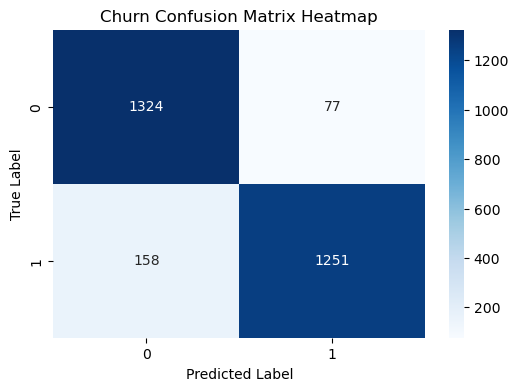

In [74]:
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Churn Confusion Matrix Heatmap')
plt.show()

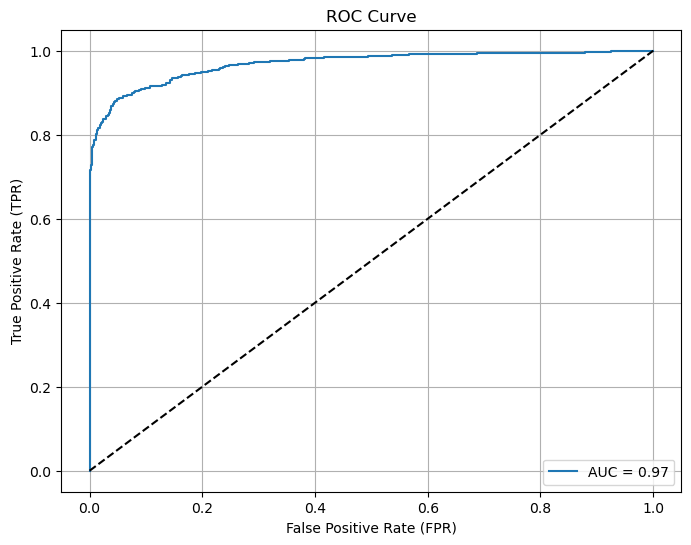

In [75]:
y_probs = model.predict_proba(X_test)[:, 1]
y_true = y_test
from sklearn.metrics import roc_curve, roc_auc_score
fpr, tpr, thresholds = roc_curve(y_true, y_probs)
auc = roc_auc_score(y_true, y_probs)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [76]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda_model= LinearDiscriminantAnalysis()

In [77]:
lda_model = lda_model.fit(X_train,y_train)

In [78]:
lday_predictions = lda_model.predict(X_test)

In [79]:
print("Accuracy = ",accuracy_score(y_test,lday_predictions))
print("Precision = ",precision_score(y_test,lday_predictions))
print("Recall = ",recall_score(y_test,lday_predictions))
print("F1 Score", f1_score(y_test,lday_predictions))

Accuracy =  0.9039145907473309
Precision =  0.950910530482977
Recall =  0.8523775727466288
F1 Score 0.8989520958083832


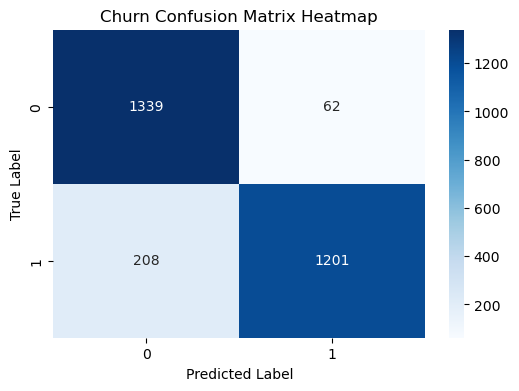

In [80]:
conf_matrix = confusion_matrix(y_test,lday_predictions)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Churn Confusion Matrix Heatmap')
plt.show()

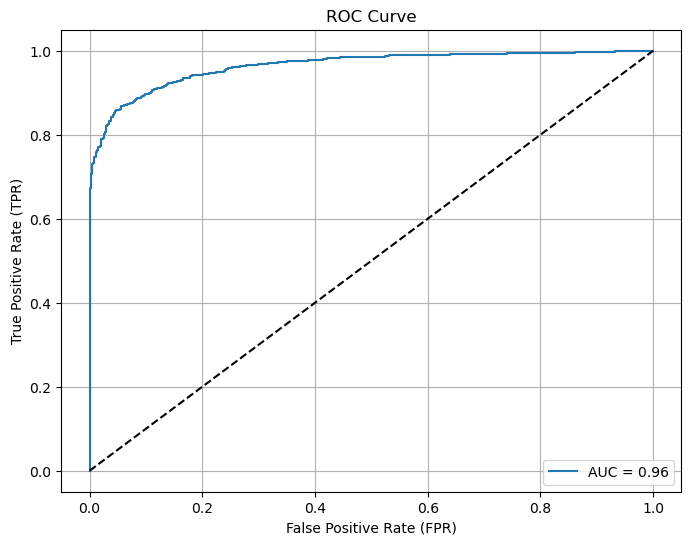

In [81]:
y_probs = lda_model.predict_proba(X_test)[:, 1]
y_true = y_test
from sklearn.metrics import roc_curve, roc_auc_score
fpr, tpr, thresholds = roc_curve(y_true, y_probs)
auc = roc_auc_score(y_true, y_probs)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [82]:
#install with pip install xgboost
import xgboost as xgb
xgb_model = xgb.XGBClassifier(random_state=1,learning_rate=0.01)
xgb_model = xgb_model.fit(X_train, y_train)

In [83]:
xgb_predictions = xgb_model.predict(X_test)

In [84]:
print("Accuracy = ",accuracy_score(y_test,xgb_predictions))
print("Precision = ",precision_score(y_test,xgb_predictions))
print("Recall = ",recall_score(y_test,xgb_predictions))
print("F1 Score", f1_score(y_test,xgb_predictions))

Accuracy =  0.9099644128113878
Precision =  0.9372163388804842
Recall =  0.879347054648687
F1 Score 0.9073599414134016


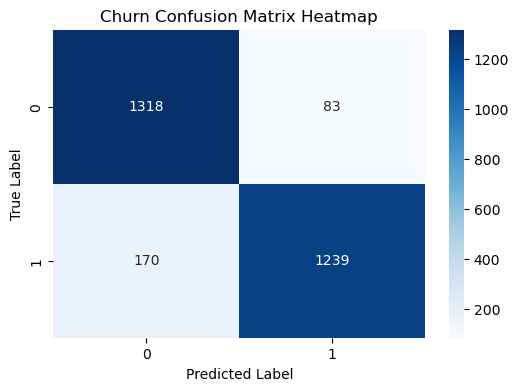

In [85]:
conf_matrix = confusion_matrix(y_test,xgb_predictions)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Churn Confusion Matrix Heatmap')
plt.show()

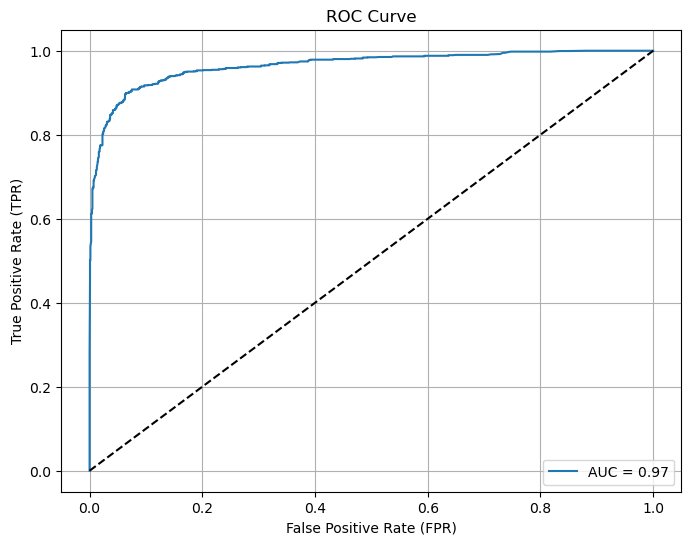

In [86]:
y_probs = xgb_model.predict_proba(X_test)[:, 1]
y_true = y_test
from sklearn.metrics import roc_curve, roc_auc_score
fpr, tpr, thresholds = roc_curve(y_true, y_probs)
auc = roc_auc_score(y_true, y_probs)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [87]:
from sklearn.ensemble import AdaBoostClassifier
ab_model = AdaBoostClassifier(n_estimators=200, random_state=42)
ab_model = ab_model.fit(X_train, y_train)

In [88]:
ab_predictions = ab_model.predict(X_test)

In [89]:
print("Accuracy = ",accuracy_score(y_test,ab_predictions))
print("Precision = ",precision_score(y_test,ab_predictions))
print("Recall = ",recall_score(y_test,ab_predictions))
print("F1 Score", f1_score(y_test,ab_predictions))

Accuracy =  0.9110320284697508
Precision =  0.9208424110384895
Recall =  0.8999290276792051
F1 Score 0.9102656137832016


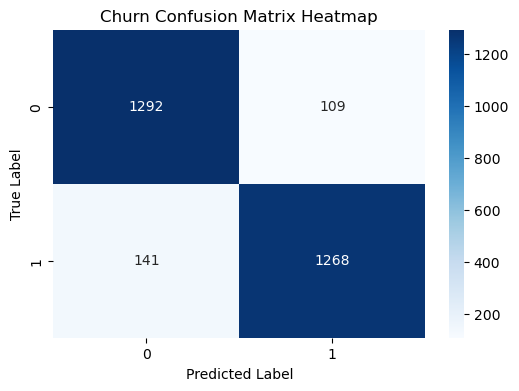

In [90]:
conf_matrix = confusion_matrix(y_test,ab_predictions)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Churn Confusion Matrix Heatmap')
plt.show()

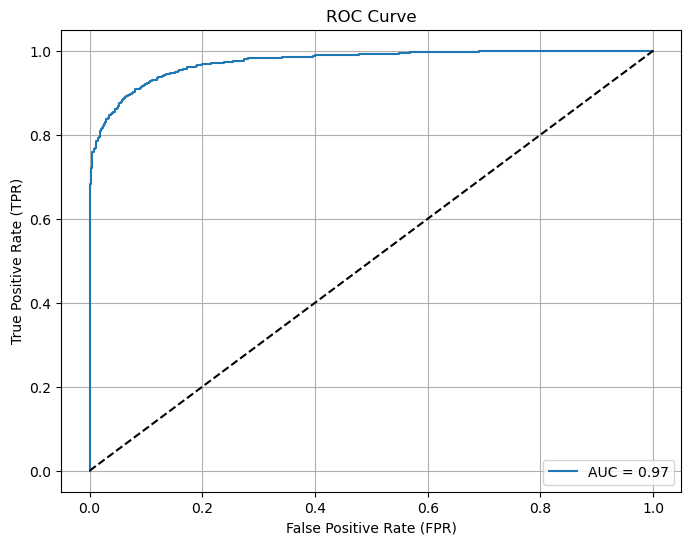

In [91]:
y_probs = ab_model.predict_proba(X_test)[:, 1]
y_true = y_test
from sklearn.metrics import roc_curve, roc_auc_score
fpr, tpr, thresholds = roc_curve(y_true, y_probs)
auc = roc_auc_score(y_true, y_probs)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [188]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
base_estimator = DecisionTreeClassifier()
adaboost = AdaBoostClassifier(base_estimator=base_estimator)


param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 1.0], 
    'algorithm': ['SAMME', 'SAMME.R'],  
    'base_estimator__splitter': ['best', 'random'],
    'base_estimator__max_depth': [1, 2, 3, None],
}

grid_search = GridSearchCV(adaboost, param_grid, cv=5)
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

best_model = grid_search.best_estimator_

accuracy = best_model.score(X_test, y_test)
print("Test Accuracy:", accuracy)

C:\Users\sreeh\anaconda3\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\sreeh\anaconda3\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\sreeh\anaconda3\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\sreeh\anaconda3\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\sreeh\anaconda3\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\sreeh\anaconda3\lib\site-p

C:\Users\sreeh\anaconda3\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\sreeh\anaconda3\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\sreeh\anaconda3\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\sreeh\anaconda3\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\sreeh\anaconda3\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\sreeh\anaconda3\lib\site-p

C:\Users\sreeh\anaconda3\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\sreeh\anaconda3\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\sreeh\anaconda3\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\sreeh\anaconda3\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\sreeh\anaconda3\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\sreeh\anaconda3\lib\site-p

C:\Users\sreeh\anaconda3\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\sreeh\anaconda3\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\sreeh\anaconda3\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\sreeh\anaconda3\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\sreeh\anaconda3\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\sreeh\anaconda3\lib\site-p

C:\Users\sreeh\anaconda3\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\sreeh\anaconda3\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\sreeh\anaconda3\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\sreeh\anaconda3\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\sreeh\anaconda3\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\sreeh\anaconda3\lib\site-p

C:\Users\sreeh\anaconda3\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\sreeh\anaconda3\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\sreeh\anaconda3\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\sreeh\anaconda3\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\sreeh\anaconda3\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\sreeh\anaconda3\lib\site-p

C:\Users\sreeh\anaconda3\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\sreeh\anaconda3\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\sreeh\anaconda3\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\sreeh\anaconda3\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\sreeh\anaconda3\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\sreeh\anaconda3\lib\site-p

C:\Users\sreeh\anaconda3\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\sreeh\anaconda3\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\sreeh\anaconda3\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\sreeh\anaconda3\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\sreeh\anaconda3\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\sreeh\anaconda3\lib\site-p

C:\Users\sreeh\anaconda3\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\sreeh\anaconda3\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\sreeh\anaconda3\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\sreeh\anaconda3\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\sreeh\anaconda3\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\sreeh\anaconda3\lib\site-p

C:\Users\sreeh\anaconda3\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\sreeh\anaconda3\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\sreeh\anaconda3\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\sreeh\anaconda3\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\sreeh\anaconda3\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\sreeh\anaconda3\lib\site-p

C:\Users\sreeh\anaconda3\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\sreeh\anaconda3\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\sreeh\anaconda3\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\sreeh\anaconda3\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\sreeh\anaconda3\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\sreeh\anaconda3\lib\site-p

C:\Users\sreeh\anaconda3\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\sreeh\anaconda3\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\sreeh\anaconda3\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\sreeh\anaconda3\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\sreeh\anaconda3\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\sreeh\anaconda3\lib\site-p

C:\Users\sreeh\anaconda3\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\sreeh\anaconda3\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\sreeh\anaconda3\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\sreeh\anaconda3\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\sreeh\anaconda3\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\sreeh\anaconda3\lib\site-p

C:\Users\sreeh\anaconda3\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\sreeh\anaconda3\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\sreeh\anaconda3\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\sreeh\anaconda3\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\sreeh\anaconda3\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\sreeh\anaconda3\lib\site-p

C:\Users\sreeh\anaconda3\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\sreeh\anaconda3\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\sreeh\anaconda3\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\sreeh\anaconda3\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\sreeh\anaconda3\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\sreeh\anaconda3\lib\site-p

C:\Users\sreeh\anaconda3\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\sreeh\anaconda3\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\sreeh\anaconda3\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\sreeh\anaconda3\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\sreeh\anaconda3\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\sreeh\anaconda3\lib\site-p

C:\Users\sreeh\anaconda3\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\sreeh\anaconda3\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\sreeh\anaconda3\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\sreeh\anaconda3\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\sreeh\anaconda3\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\sreeh\anaconda3\lib\site-p

Best Hyperparameters: {'algorithm': 'SAMME.R', 'base_estimator__max_depth': 3, 'base_estimator__splitter': 'best', 'learning_rate': 1.0, 'n_estimators': 200}
Test Accuracy: 0.9718861209964412


In [189]:
ab1_predictions = best_model.predict(X_test)

In [190]:
print("Accuracy = ",accuracy_score(y_test,ab1_predictions))
print("Precision = ",precision_score(y_test,ab1_predictions))
print("Recall = ",recall_score(y_test,ab1_predictions))
print("F1 Score", f1_score(y_test,ab1_predictions))

Accuracy =  0.9718861209964412
Precision =  0.9656862745098039
Recall =  0.978708303761533
F1 Score 0.9721536834684525


In [95]:
from sklearn.svm import SVC
svmclf = SVC(kernel='linear')
svmclf.fit(X_train,y_train)

SVC(kernel='linear')

In [96]:
y_pred = svmclf.predict(X_test)
print("Accuracy = ",accuracy_score(y_test,y_pred))
print("Precision = ",precision_score(y_test,y_pred))
print("Recall = ",recall_score(y_test,y_pred))
print("F1 Score", f1_score(y_test,y_pred))

Accuracy =  0.9120996441281138
Precision =  0.9394856278366112
Recall =  0.8814762242725337
F1 Score 0.909556938850238


In [96]:
from sklearn.neighbors import KNeighborsClassifier
metric_k = []
neighbors = np.arange(1,15)

In [97]:
for k in neighbors:
    classifier = KNeighborsClassifier(n_neighbors = k,metric ='euclidean')
    classifier.fit(X_train,y_train)
    y_predictions = classifier.predict(X_test)
    acc = accuracy_score(y_test,y_predictions)
    metric_k.append(acc)

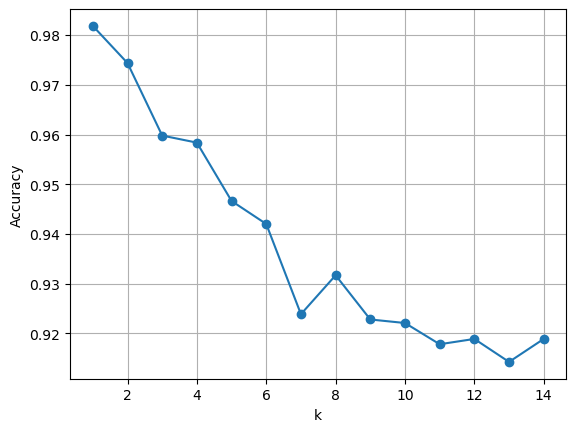

In [98]:
plt.plot(neighbors,metric_k,'o-')
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.grid()
plt.show()

In [100]:
classifier = KNeighborsClassifier(n_neighbors = 1,metric ='euclidean')
classifier.fit(X_train,y_train)
y_predictions = classifier.predict(X_test)

In [101]:
print("Accuracy = ",accuracy_score(y_test,y_predictions))
print("Precision = ",precision_score(y_test,y_predictions))
print("Recall = ",recall_score(y_test,y_predictions))
print("F1 Score", f1_score(y_test,y_predictions))
confusion_matrix(y_test,y_predictions)

Accuracy =  0.9818505338078292
Precision =  0.9761570827489481
Recall =  0.9879347054648687
F1 Score 0.9820105820105821


array([[1367,   34],
       [  17, 1392]], dtype=int64)